# Repito el mismo ejercicio pero en este caso para el Otomí

In [1]:
!pip install elotl

In [2]:
from collections import defaultdict, Counter
import elotl.corpus
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
plt.rcParams['figure.figsize'] = [15, 6]
import numpy as np
import networkx as nx
import statsmodels.api as sm
import os
from re import sub

In [3]:
corpusOtomi=elotl.corpus.load('tsunkua')  #español-otomi 

In [4]:
def getWords(corpus):
    ### Vamos a extraer la lista de palabras para cada lengua en cada corpus: 
    corpusEs=[]
    corpusEx=[] 
    palabras=[] ### Lista temporal

    ### Iteramos sobre cada línea de los corpus y vamos guardando las palabras que corresponden a cada lengua:
    ###Corpus español-náhuatl
    for row in corpus:   
      ### row[0]: corresponde con las oraciones en español
      row[0]=sub(r'[^\w\s]',' ',row[0])     #Sustituimos signos de puntuación por un espacio
      palabras=row[0].lower().split()       #Dividimos a la oración en palabras (el delimitador es un espacio). Luego, guardamos cada una de estas palabras en la lista palabras
      for p in palabras:                    #Iteramos sobre cada palabra de la oración (lista palabras)
           corpusEs.append(p)             #vamos agregando cada palabra a una lista (corpus1_es)
      ### row[1]: corresponde con las oraciones en nahuatl   
      row[1]=sub(r'[^\w\s\']',' ',row[1])  #Sustituimo signos de puntuación por un espacio. Notemos que aparece este signo "'", también lo quitamos.
      palabras=row[1].lower().split()      #Dividimos a la oración en palabras (el delimitador es un espacio). Luego, guardamos cada una de estas palabras en la lista palabras
      for p in palabras:                      #Iteramos sobre cada palabra de la oración (lista palabras)
           corpusEx.append(p)            #vamos agregando cada palabra a una lista (corpus1_na)
    return corpusEs,corpusEx

In [5]:
palabras2 = getWords(corpusOtomi)
lenguajes2 = ["español","otomi"]

In [6]:
for i in range(2):
    print("Lenguaje: {0}".format(lenguajes2[i]))
    # número de palabras totales
    print("Palabras totales: {0}".format(len(palabras2[i])))
    # número de palabras distintas
    print("Palabras distintas: {0}".format(len(set(palabras2[i]))))

Lenguaje: español
Palabras totales: 56893
Palabras distintas: 8712
Lenguaje: otomi
Palabras totales: 68540
Palabras distintas: 7480


In [7]:
def plotLogLog(xs,ys,title,fit=True,norm=True):
    plt.figure()
    if norm:
        s = sum(ys)
        ys = [y/s for y in ys]
        plt.ylabel("Normalized Frecuency")
    else:
        plt.ylabel("Frecuency")

    plt.plot(xs,ys,label="Data")
    bins = np.logspace(0, 3, 50)
    widths = (bins[1:] - bins[:-1])
    plt.xscale("log")
    plt.yscale("log")
    plt.title(title)
    plt.grid()
    if fit:
        # making linear power-law regression using statsmodels
        # adding constant term to x
        xsfit = sm.add_constant(np.log(xs))
        # build model and train
        mod = sm.OLS(exog=xsfit,endog=np.log(ys))
        fit = mod.fit()
        # make list of predicted data
        ysfit = [np.exp(y) for y in fit.predict(xsfit)]
        # plotting results
        plt.plot(xs,ysfit,label="Power law fit")
        # digits for exponent and coefficient
        r1 = 4
        textstr = "y = {0} x^({1}) \n R^2 = {2}".format(round(np.exp(fit.params[0]),r1),round(fit.params[1],r1),round(fit.rsquared,8))
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        plt.text(len(xs), ys[0]*1.2, textstr,  fontsize=14,va='top',ha="right", bbox=props)
    plt.show()

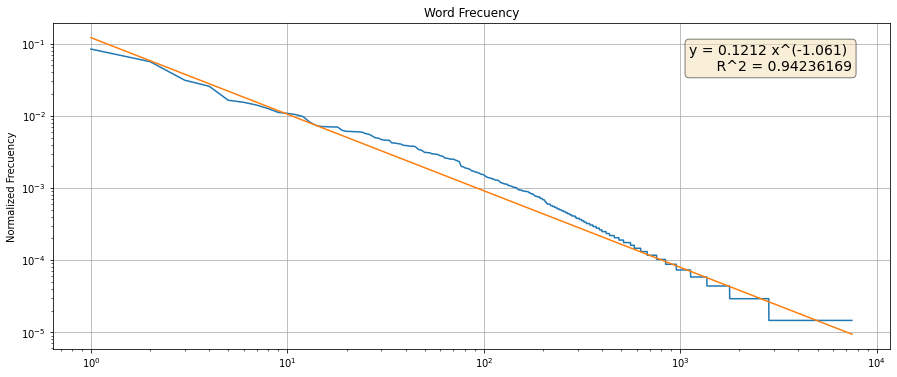

In [8]:
# plotting frecuency
counter = Counter(palabras2[1])
vals = counter.most_common()
xs = range(1,len(counter.values())+1)
ys = [val[1] for val in vals]
plotLogLog(xs,ys,"Word Frecuency",fit=True)

## Building concurrency network (Otomí)

In [9]:
concDG = nx.DiGraph()
concDG.add_nodes_from(set(palabras2[1]))
concDG.add_edges_from(zip(palabras2[1][1:],palabras2[1][:-1]))
nx.readwrite.graphml.write_graphml(concDG,os.path.join("networks","concurrency_esp.graphml"))

In [10]:
#### Algunas funciones solo corren para gráficas simples G.
concG = nx.Graph()
concG.add_nodes_from(set(palabras2[1]))
concG.add_edges_from(zip(palabras2[1][1:],palabras2[1][:-1]))


In [11]:
nx.write_gexf(concDG,"red_otomi.gexf",version="1.2draft")

In [12]:
def plotDegreeDistributions(G,title,fit=False,norm=True):
    if type(G) == nx.classes.digraph.DiGraph:
        degs = ["degree","in_degree","out_degree"]
    else:
        degs = ["degree"]
    for deg in degs:
        func = getattr(G,deg)
        degreeSequence = sorted([d for n,d in func()])
        degreeCounter = Counter(degreeSequence)
        degrees, count = zip(*degreeCounter.items())
        plotLogLog(degrees,count,"{1} \n {0} distribution".format(deg.replace("_"," "),title),fit=fit,norm=norm)

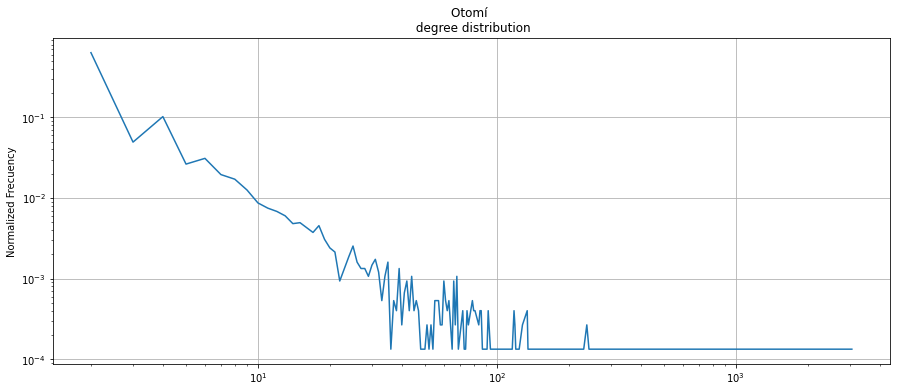

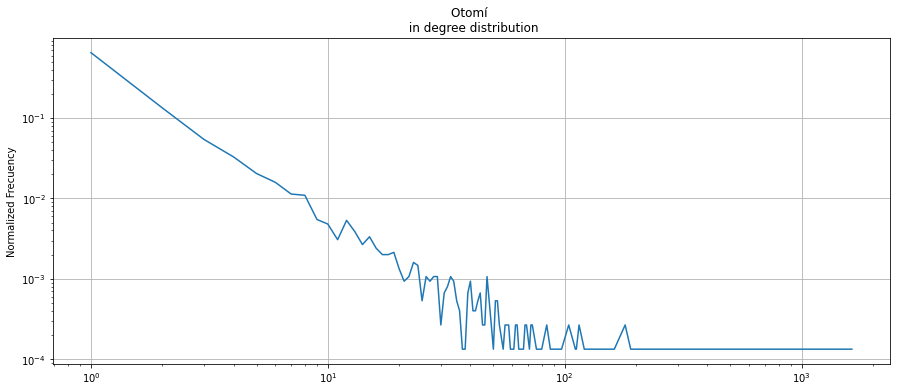

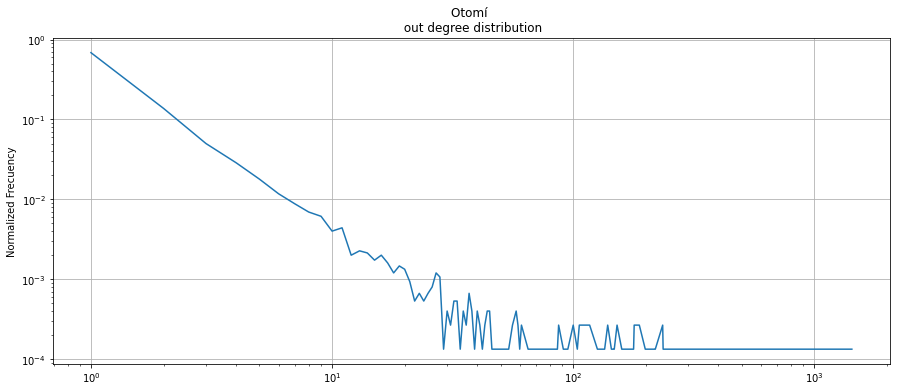

In [13]:
plotDegreeDistributions(concDG,"Otomí",fit=False,norm=True)

## Métricas de la Red

In [14]:
orden = concDG.order()
tamano = concDG.size()
print('La red tiene %d nodos y %d enlaces'%(orden,tamano))

La red tiene 7480 nodos y 31527 enlaces


In [15]:
densidad = (2 * tamano)/(orden *(orden-1) )
print('La densidad de la red es: %f'%(densidad))

La densidad de la red es: 0.001127


In [16]:
coef_clustering = len(nx.clustering(concG))
print('El coeficiente de clustering es : %d' %(coef_clustering))

El coeficiente de clustering es : 7480


## Métricas del Corpus Español-Otomí 

In [17]:
size_corpusOtomi=len(corpusOtomi)

print("Oraciones paralelas en corpus español-otomí:", size_corpusOtomi)

Oraciones paralelas en corpus español-otomí: 4963


In [21]:
## Palabra más larga en otomí
print (max(palabras2[1], key=len))

aquiyahualcatecuhtli


In [22]:
## Palabra más corta en otomí
print (min(palabras2[1], key=len))

o


In [23]:
### Longitud promedio de una palabra
def avg_length(corpus):
   total=0
   sizeprev=0
   for p in corpus:
    size=len(p)
    if sizeprev<size:
      sizeprev=size
      longest_string=p
    total=total+size
   avg=total/len(corpus)
   return avg

In [24]:
print ("Longitud promedio de palabra en otomí (corpus2):", avg_length(palabras2[1]))
print ("Longitud promedio de palabra en español (corpus2):", avg_length(palabras2[0]))

Longitud promedio de palabra en otomí (corpus2): 3.5798657718120803
Longitud promedio de palabra en español (corpus2): 4.672033466331535


## Ley de Zipf 

In [19]:
## Convertimos a diccionario (palabra,frecuencia)
corpus2_otomi=Counter(palabras2[1])
corpus2_espanol=Counter(palabras2[0])

In [25]:
## Las 20 palabras más comunes del otomí en el corpus 2
corpus2_otomi.most_common(20)

[('ra', 5770),
 ('ya', 3861),
 ('bi', 2138),
 ('mi', 1760),
 ('ne', 1127),
 ('da', 1055),
 ('ha', 963),
 ('di', 861),
 ('ma', 763),
 ("n'a", 741),
 ('pa', 713),
 ('ge', 671),
 ('ko', 560),
 ("nu'a", 504),
 ('xki', 486),
 ('ngu', 484),
 ('ri', 480),
 ('o', 480),
 ('nuya', 431),
 ('nuna', 418)]

In [26]:
## Las 20 palabras más comunes del español en el corpus 2
corpus2_espanol.most_common(20)

[('de', 3011),
 ('y', 1647),
 ('los', 1593),
 ('a', 1575),
 ('que', 1538),
 ('la', 1386),
 ('en', 1325),
 ('el', 1257),
 ('se', 1215),
 ('no', 573),
 ('lo', 572),
 ('con', 545),
 ('por', 515),
 ('las', 488),
 ('su', 390),
 ('pues', 379),
 ('un', 360),
 ('del', 352),
 ('al', 340),
 ('como', 330)]

In [27]:
## Esta es una función que recibe un diccionario de palabra,frecuencia (c) y un umbral (n). 
## Nos regresa una lista con las (n) frecuencias más altas del diccionario
def get_freqs(c, n): 
  freqs=[]
  pairs=c.most_common(n)  ###Esta función solo jala con un diccionario
  for p in pairs:
    freqs.append(p[1])
  return freqs   

Text(0.5, 1.0, 'Frecuencia de las palabras en Otomí(corpus2)')

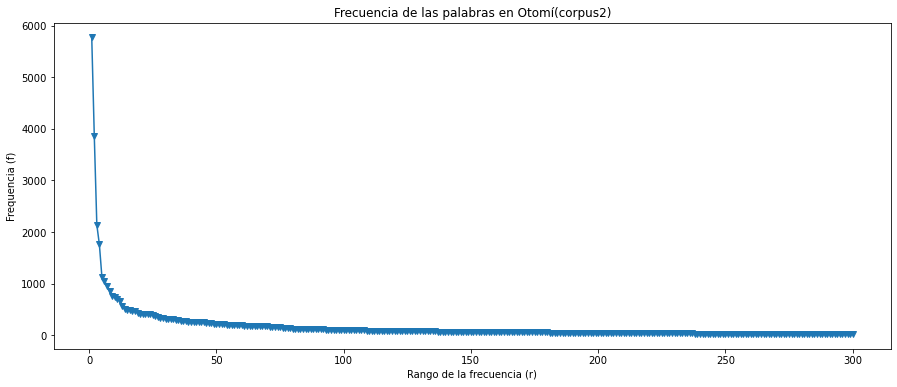

In [29]:
freq_otomi=get_freqs(corpus2_otomi, 300)  #Obtenemos las n frecuencias más altas (ordenadas) y las guardamos en una lista
x = list(range(1, 301))                  #Generamos una lista con números del 1 al n. Esto será el eje de las X en la gráfica, la frecuencia más grande ocupa el ranking 1

## Graficamos
plt.plot(x, freq_otomi,'-v')
plt.xlabel('Rango de la frecuencia (r)')
plt.ylabel('Frequencia (f)')
plt.title('Frecuencia de las palabras en Otomí(corpus2)')

Text(0.5, 1.0, 'Frecuencia de las palabras en Español(corpus2)')

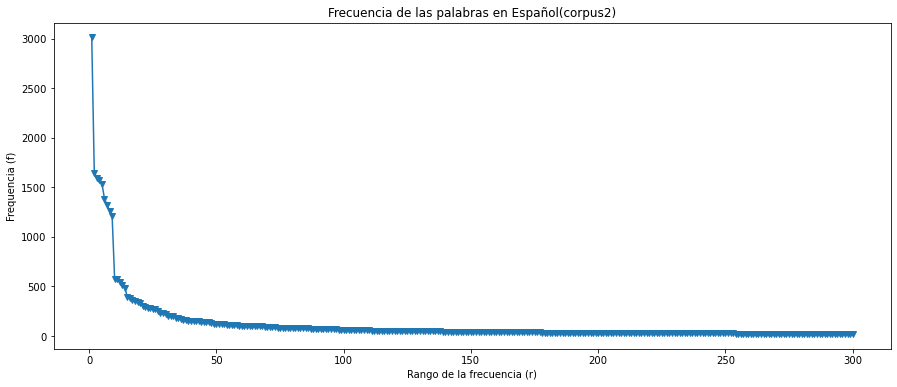

In [30]:
freq_espanol=get_freqs(corpus2_espanol, 300)  #Obtenemos las n frecuencias más altas (ordenadas) y las guardamos en una lista
x = list(range(1, 301))                  #Generamos una lista con números del 1 al n. Esto será el eje de las X en la gráfica y servirá para indicar la frecuencia más grande ocupa el ranking 1

## Graficamos
plt.plot(x, freq_espanol,'-v')
plt.xlabel('Rango de la frecuencia (r)')
plt.ylabel('Frequencia (f)')
plt.title('Frecuencia de las palabras en Español(corpus2)')

Text(0.5, 1.0, 'Frecuencia de las palabras en Corpus2')

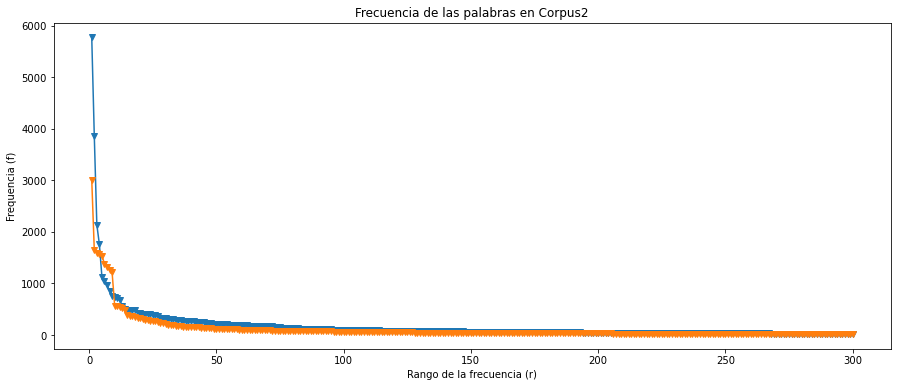

In [32]:
plt.figure()
plot2=plt.plot(x, freq_otomi,'-v')
plot3=plt.plot(x, freq_espanol,'-v')
plt.xlabel('Rango de la frecuencia (r)')
plt.ylabel('Frequencia (f)')
plt.title('Frecuencia de las palabras en Corpus2')

Text(0.5, 1.0, 'Frecuencia de las palabras')

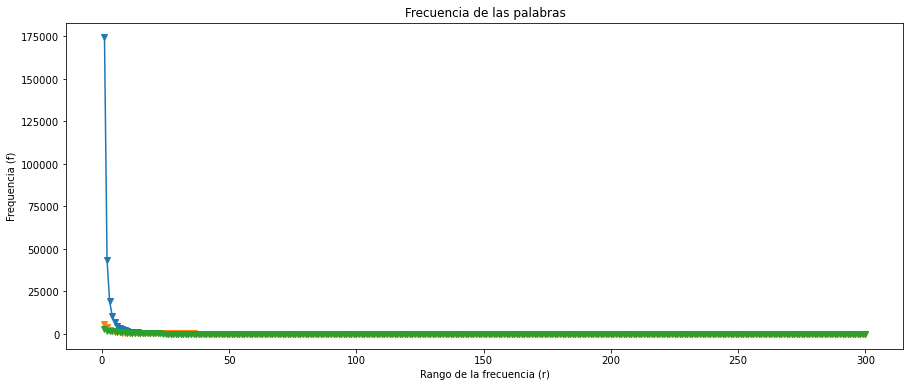

In [34]:
## Vamos a generar una distribución de Zipf con números aleatorios(https://numpy.org/doc/stable/reference/random/generated/numpy.random.zipf.html)
a = 2                           # parametro alpha*
s = np.random.zipf(a, 286805)   
s_voc=Counter(s)                #Usando Counter obtenemos un diccionario de las frecuencias de cada número generado


frequency=get_freqs(s_voc, 300)  

## Juntamos las tres curvas
plt.figure()
plot1=plt.plot(x, frequency,'-v')
plot2=plt.plot(x, freq_otomi,'-v')
plot3=plt.plot(x, freq_espanol,'-v')
plt.xlabel('Rango de la frecuencia (r)')
plt.ylabel('Frequencia (f)')
plt.title('Frecuencia de las palabras')